<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/Late_fusion_effnet_lesion_attention_res_blocks_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import sys
import random
import IPython

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

from matplotlib.pyplot import imread
from cv2 import resize

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
#import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow


In [3]:
tf.__version__,tf. config. list_physical_devices()

('2.4.1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

## Read, Split train_val & oversample train set


In [4]:
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed 512_Size sigma8/file1.csv"
#dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/ Ben_Processed 512_Size sigma8"
df = pd.read_csv(dataset_groundtruth_location)
#img_loc=[]
#for i in range(516):
#  img_loc.append(dataset_images_location+'/'+str(i)+'.jpg')
#df['processed_img_loc'] = img_loc
test_df=df[-103:].reset_index(drop=True)[['processed_img_loc','Retinopathy grade']]
df=df[0:413].reset_index(drop=True)[['processed_img_loc','Retinopathy grade']]
train_df, val_df = train_test_split(df, test_size = 0.001, random_state = 25);
train_df.head()

,processed_img_loc,Retinopathy grade
224,/content/drive/My Drive/IDRid/B. Disease Gradi...,0
23,/content/drive/My Drive/IDRid/B. Disease Gradi...,4
153,/content/drive/My Drive/IDRid/B. Disease Gradi...,0
94,/content/drive/My Drive/IDRid/B. Disease Gradi...,3
325,/content/drive/My Drive/IDRid/B. Disease Gradi...,2


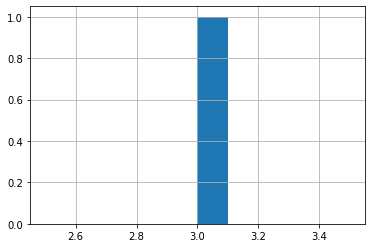

In [5]:
val_df['Retinopathy grade'].hist()

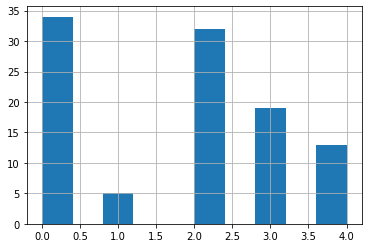

In [6]:
test_df['Retinopathy grade'].hist()

In [7]:
def balance_data(class_size, df):
    train_df = df.groupby(['Retinopathy grade']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['Retinopathy grade'].hist(figsize = (10, 5))
    return train_df

New Data Size: 680 Old Size: 412


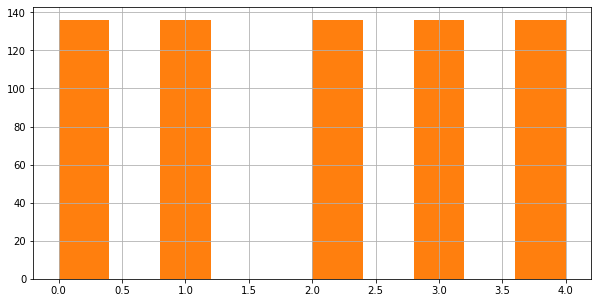

In [29]:
train_df = balance_data(train_df.pivot_table(index='Retinopathy grade', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['Retinopathy grade'].hist(figsize = (10, 5))

In [8]:
train_df['Retinopathy grade']=train_df['Retinopathy grade'].astype('str')
#val_df['Retinopathy grade'] =val_df['Retinopathy grade'].astype('str')
test_df['Retinopathy grade'] =test_df['Retinopathy grade'].astype('str')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
BATCH_SIZE = 4
IMG_WIDTH, IMG_HEIGHT=512,512

configs=dict( rescale=1/255.0,
              rotation_range=30,
              horizontal_flip=True,
              vertical_flip=True,
              zoom_range=[0.75,1],
              width_shift_range=1.1,
              height_shift_range=0.05,
              fill_mode='nearest')
# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(**configs,validation_split=0.1)
# Use the dataframe to define train and validation generators
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='processed_img_loc', 
                                                    y_col='Retinopathy grade',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    subset='training',
                                                    batch_size=BATCH_SIZE)
#val_datagen = ImageDataGenerator(**configs)
                                
val_generator = train_datagen.flow_from_dataframe(  train_df, 
                                                  x_col='processed_img_loc', 
                                                  y_col='Retinopathy grade',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  subset='validation',
                                                  batch_size=BATCH_SIZE
                                                  )

Found 371 validated image filenames belonging to 5 classes.
Found 41 validated image filenames belonging to 5 classes.


In [10]:
test_image_names = [];
test_image_names = test_df['processed_img_loc'];
print("len of test set ",len(test_image_names))
im_size = 512;

test_labels = [];
test_labels = test_df['Retinopathy grade'];

test_images = np.zeros((103,512,512,3))
ind=0
for image_name in test_image_names:
    test_images[ind] = imread(image_name)
    ind+=1
test_images = test_images /255.0
test_labels = np.array(test_labels, ndmin = 2)
test_labels = np.transpose(test_labels)

enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
enc.fit(test_labels)
test_labels = enc.transform(test_labels)

print(test_images.shape)
print(test_labels.shape) 

len of test set  103
(103, 512, 512, 3)
(103, 5)


In [11]:
test_datagen = ImageDataGenerator(**configs)
test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                  x_col='processed_img_loc', 
                                                  y_col='Retinopathy grade',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=4
                                                  )

Found 103 validated image filenames belonging to 5 classes.


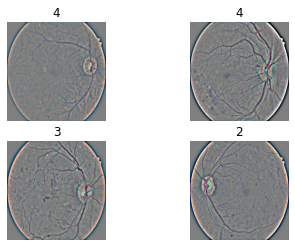

In [12]:
for i in range(4):
  ax=plt.subplot(2,2,i+1)
  plt.imshow(test_images[2*i+1])
  plt.title("{}".format(np.argmax(test_labels[2*i+1]))) 
  plt.axis('off')

1.0


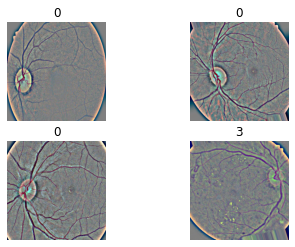

In [13]:
for i,(img,lbl) in enumerate(train_generator):
  print(np.max(img))
  for j in range(4):
    ax=plt.subplot(2,2,j+1)  
    plt.imshow(img[j])
    plt.title("{}".format(np.argmax(lbl[j]))) 
    plt.axis('off')
  break

In [14]:
from keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB4
#from tensorflow.keras.applications.densenet import DenseNet121#,Resnet50
from keras.models import Model

## Load Segmentation model 


In [15]:
from tensorflow.keras.models import model_from_json
def load_seg_model(model_name):
    # # load json and create model
    json_file = open('/content/drive/MyDrive/IDRid/Experimental models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # # load weights into new model
    loaded_model.load_weights("/content/drive/MyDrive/IDRid/Experimental models/{}.h5".format(model_name))
    # # evaluate loaded model on test data
    loaded_model.compile()
    print(model_name," Model loaded and compiled")
    return loaded_model

In [16]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    # Retrieve Filters
    F1, F2, F3 = filters
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
  
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
  
    # Save the input value
    X_shortcut = X
    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path 
    X = Conv2D(F2, (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer=glorot_uniform(seed =0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu') (X)

    # Third component of main path 
    X = Conv2D(F3, (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer=glorot_uniform(seed =0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer=glorot_uniform(seed =0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X


In [18]:
def build_model(num_classes,model_name):
    IMG_SIZE=512
    NUM_CLASSES=num_classes
    # define inputs
    input_0 =layers.Input(shape=(512,512, 3))
    input_1=tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE,  name='resize_input')(input_0)
    if model_name=='DenseNet121':
      base_model = DenseNet121(include_top=False, input_tensor=input_1, weights="imagenet")
    elif model_name=='EfficientNetB4':
      base_model = EfficientNetB4(include_top=False, input_tensor=input_1*255, weights="imagenet")
    ex_model=load_seg_model("seg_EX_ben_sigm8_5l_3f")
    ma_model=load_seg_model("seg_MA_ben_sigm8_2l_26f")
    se_model=load_seg_model("seg_SE_ben_sigm8_4l_4f")
    he_model=load_seg_model("seg_HE_ben_sigm8_6l_4f")
    # Freeze the pretrained weights
    base_model.trainable = False
    ex_model.trainable=False
    se_model.trainable=False
    ma_model.trainable=False
    he_model.trainable=False
    ex_model._name='model_ex'
    ma_model._name='model_ma'
    se_model._name='model_se'
    he_model._name='model_he'
    #pass image for lesion
    les_ex=ex_model(input_0)
    les_se=se_model(input_0)
    les_ma=ma_model(input_0)
    les_he=he_model(input_0)

    #attention based input
    att=layers.Concatenate(name='concat_lesion')([les_ex,les_se,les_ma,les_he])
    W_g=keras.layers.Conv2D(6, kernel_size=1, padding='same', strides=1,name='Wg')(att)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    #input image
    W_x=keras.layers.Conv2D(6, kernel_size=1, padding='same', strides=1,name='Wx')(input_0)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    # convolve to  attention filter
    att=layers.Add(name='additive_enhance_layer')([W_x,W_g])
    att=tf.keras.activations.relu(att, alpha=0.0, max_value=None, threshold=0)
    att=keras.layers.Conv2D(3, kernel_size=1, padding='same', strides=1)(att)
    att=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(att))
    f_lesions=tf.keras.layers.Multiply()([att,input_0])
    #print(f_lesions.shape)
    #block1
    f_lesions=convolutional_block(f_lesions,3,(3,3,16),1,'a')
    f_lesions=identity_block(f_lesions,3,(3,3,16),1,'b')
    #block2
    f_lesions=convolutional_block(f_lesions,3,(16,16,32),2,'a')
    f_lesions=identity_block(f_lesions,3,(16,16,32),2,'b')
    #block3
    f_lesions=convolutional_block(f_lesions,3,(32,32,64),3,'a')
    f_lesions=identity_block(f_lesions,3,(32,32,64),3,'b')
    #f_lesions=identity_block(f_lesions,3,(32,32,64),3,'c')
    #block 4
    f_lesions=convolutional_block(f_lesions,3,(64,64,128),4,'a')
    f_lesions=identity_block(f_lesions,3,(64,64,128),4,'b')
    f_lesions=identity_block(f_lesions,3,(64,64,128),4,'c')
    #f_lesions=identity_block(f_lesions,3,(64,64,128),4,'d')
    
    #block 5
    f_lesions=convolutional_block(f_lesions,3,(128,128,256),5,'a')
    f_lesions=identity_block(f_lesions,3,(128,128,256),5,'b')
    f_lesions=identity_block(f_lesions,3,(128,128,256),5,'c')
    #f_lesions=identity_block(f_lesions,3,(128,128,256),5,'d')
    #f_lesions=identity_block(f_lesions,3,(128,128,256),5,'e')

    #pooling
    f_lesions=layers.GlobalAveragePooling2D()(f_lesions)
    #print(f_lesions.shape)
    top_dropout_rate = 0.2
   
    #predection_2
    x=base_model.output
    x=layers.GlobalAveragePooling2D()(x)
    x=layers.Concatenate()([x,f_lesions])
    # Rebuild top
    x = Flatten(name="flatten_2")(x)
    x = Dropout(top_dropout_rate, name="top_dropout_1")(x)
    x = Dense(256, activation="relu", name="last_dense_2")(x)
    x = Dropout(top_dropout_rate, name="top_dropout_2")(x)
    x = Dense(NUM_CLASSES, activation="softmax", name="pred_2")(x)
  
    # Compile
    model = tf.keras.Model(input_0, x, name="Segnet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.9)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [19]:
random.seed = 42
tf.seed = 42
tf.random.set_seed(42)
model=build_model(5,'EfficientNetB4')

seg_EX_ben_sigm8_5l_3f  Model loaded and compiled
seg_MA_ben_sigm8_2l_26f  Model loaded and compiled
seg_SE_ben_sigm8_4l_4f  Model loaded and compiled
seg_HE_ben_sigm8_6l_4f  Model loaded and compiled


In [20]:
from keras.utils.layer_utils import count_params
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)
print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 22,616,426
Trainable params: 1,389,741
Non-trainable params: 21,226,685


In [ ]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=48,
)

In [22]:
random.seed = 42
tf.seed = 42
tf.random.set_seed(42)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3,beta_1=0.9)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='auto', verbose=1, patience=4)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto',  
                        min_delta=0.01)
hist=model.fit(train_generator,steps_per_epoch=len(train_generator) , 
               epochs =20, callbacks = [es,rlr],validation_data=val_generator,validation_steps=len(val_generator));

Epoch 1/20
93/93 [==============================] - 136s 824ms/step - loss: 1.6997 - accuracy: 0.4097 - val_loss: 1.0926 - val_accuracy: 0.5366
Epoch 2/20
93/93 [==============================] - 50s 537ms/step - loss: 1.0700 - accuracy: 0.5543 - val_loss: 0.9936 - val_accuracy: 0.5366
Epoch 3/20
93/93 [==============================] - 50s 534ms/step - loss: 1.0777 - accuracy: 0.5323 - val_loss: 1.1053 - val_accuracy: 0.4878
Epoch 4/20
93/93 [==============================] - 50s 536ms/step - loss: 1.0262 - accuracy: 0.5456 - val_loss: 1.2117 - val_accuracy: 0.5366
Epoch 5/20
93/93 [==============================] - 50s 534ms/step - loss: 0.9117 - accuracy: 0.5947 - val_loss: 0.9094 - val_accuracy: 0.5610
Epoch 6/20
93/93 [==============================] - 50s 535ms/step - loss: 0.8913 - accuracy: 0.6190 - val_loss: 1.3256 - val_accuracy: 0.5854
Epoch 7/20
93/93 [==============================] - 50s 536ms/step - loss: 0.8800 - accuracy: 0.6102 - val_loss: 0.9133 - val_accuracy: 0.682

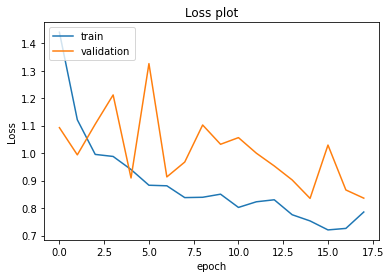

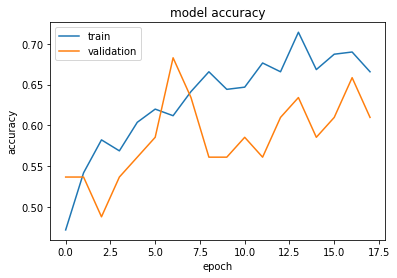

In [23]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss plot")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [25]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score,accuracy_score
def quadratic_kappa(y_hat, y):
    return cohen_kappa_score(y_hat, y, weights='quadratic')

[[19  0  0  0  0]
 [ 2  0  0  0  0]
 [ 2  0  7  1  0]
 [ 0  0  6  4  1]
 [ 0  0  1  1  0]]
accuracy  0.6818181818181818  accuracy
quadratic kappa  0.8523920653442241


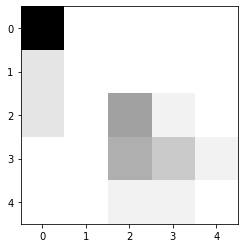

In [26]:
pred_y_=np.zeros((len(val_generator)*4,5))
val_y_=np.zeros((len(val_generator)*4,5))
for i,(img,lbl) in enumerate(val_generator):
  pred_y_[4*i:4*i+4]=model.predict(img)
  val_y_[4*i:4*i+4,:]=lbl
  # run for loop len(val_generator) as it will cover all the images in test data i.e. last batch will be of 3 images
  if i==len(val_generator)-1:
    break
pred_y_=pred_y_
cm=confusion_matrix(np.argmax(val_y_,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
#print(" precision_score ",precision_score(np.argmax(val_y_,axis=1),np.argmax(pred_y_,axis=1))," precision")
print("accuracy ",accuracy_score(np.argmax(val_y_,axis=1),np.argmax(pred_y_,axis=1))," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(val_y_,axis=1)))

[[30  0  4  0  0]
 [ 4  0  1  0  0]
 [ 6  0 25  0  1]
 [ 2  0  8  6  3]
 [ 1  0  6  1  5]]
0.6407766990291263  accuracy
quadratic kappa  0.6978429680759275


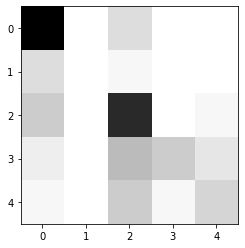

In [27]:
pred_y_=np.zeros((test_labels.shape))
for i in range(26):
  pred_y_[4*i:4*i+4]=model.predict(test_images[4*i:4*i+4])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(test_labels,axis=1)))

## acc with TTA

[[29  0  5  0  0]
 [ 3  0  2  0  0]
 [ 6  0 26  0  0]
 [ 2  0  9  7  1]
 [ 1  0  8  1  3]]
0.6310679611650486  accuracy
quadratic kappa  0.6539569112627986


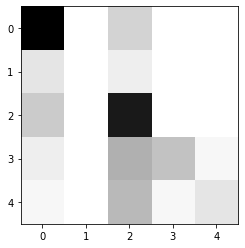

In [35]:
pred_y_tta=np.zeros((103,5))
test_y_=np.zeros((103,5))
for i,(img,lbl) in enumerate(test_generator):
  #print(img.shape,lbl.shape)
  pred_y_tta[4*i:4*i+4]=model.predict(img)
  test_y_[4*i:4*i+4,:]=lbl
  if i==25:
    break
cm=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_tta,axis=1),np.argmax(test_y_,axis=1)))

## unfreeze and train

In [29]:
count=0
model.trainable=True
for layer in model.layers:
  if layer.name[-2:] == 'bn':
    layer.trainable=False
    count+=1
  if layer.name[-2:] in ['he','ex','se','ma' ]:
    layer.trainable=False
    print(layer.name," freezed")
    count+=1
print(count-4," layers of bn freezed+ 4 seg model freezed")
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)
print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

model_ex  freezed
model_se  freezed
model_ma  freezed
model_he  freezed
96  layers of bn freezed+ 4 seg model freezed
Total params: 22,616,426
Trainable params: 18,813,157
Non-trainable params: 3,803,269


In [36]:
random.seed = 42
tf.seed = 42
tf.random.set_seed(42)
from keras.callbacks import ModelCheckpoint
filepath="weights.{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

opt = keras.optimizers.Adam(learning_rate = 1e-5, beta_1 = 0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 5)
hist1=model.fit(train_generator,steps_per_epoch=len(train_generator) , 
               epochs =10, callbacks = [es,rlr,checkpoint],validation_data=val_generator,validation_steps=len(val_generator));

Epoch 1/10
93/93 [==============================] - 129s 1s/step - loss: 0.7578 - accuracy: 0.6604 - val_loss: 0.8470 - val_accuracy: 0.6585

Epoch 00001: val_accuracy improved from -inf to 0.65854, saving model to weights.01-0.66.hdf5
Epoch 2/10
93/93 [==============================] - 93s 996ms/step - loss: 0.6645 - accuracy: 0.7294 - val_loss: 0.9059 - val_accuracy: 0.6585

Epoch 00002: val_accuracy did not improve from 0.65854
Epoch 3/10
93/93 [==============================] - 92s 991ms/step - loss: 0.5991 - accuracy: 0.7643 - val_loss: 0.7600 - val_accuracy: 0.6829

Epoch 00003: val_accuracy improved from 0.65854 to 0.68293, saving model to weights.03-0.68.hdf5
Epoch 4/10
93/93 [==============================] - 93s 992ms/step - loss: 0.5580 - accuracy: 0.7929 - val_loss: 0.7748 - val_accuracy: 0.7317

Epoch 00004: val_accuracy improved from 0.68293 to 0.73171, saving model to weights.04-0.73.hdf5
Epoch 5/10
93/93 [==============================] - 93s 994ms/step - loss: 0.5774 -

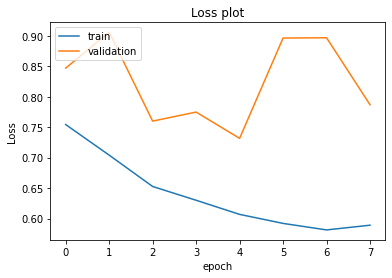

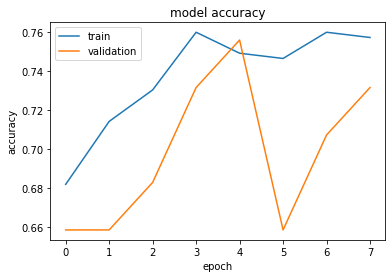

In [37]:
plt.plot(hist1.history["loss"])
plt.plot(hist1.history["val_loss"])
plt.title("Loss plot")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(hist1.history["accuracy"])
plt.plot(hist1.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

[[31  0  3  0  0]
 [ 4  0  1  0  0]
 [ 5  0 27  0  0]
 [ 2  0  6  7  4]
 [ 1  0  6  0  6]]
0.6893203883495146  accuracy
quadratic kappa  0.7367908686023024


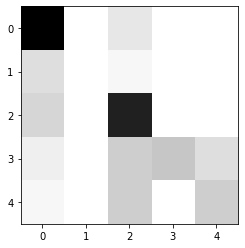

In [38]:
pred_y_=np.zeros((test_labels.shape))
for i in range(26):
  pred_y_[4*i:4*i+4]=model.predict(test_images[4*i:4*i+4])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(test_labels,axis=1)))

In [46]:
test_datagen = ImageDataGenerator( rescale=1/255.0,
              rotation_range=30,
              horizontal_flip=True,
              vertical_flip=True,
              zoom_range=[0.75,1],
              width_shift_range=1.1,
              height_shift_range=0.05,
              fill_mode='nearest')
test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                  x_col='processed_img_loc', 
                                                  y_col='Retinopathy grade',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=4
                                                  )

Found 103 validated image filenames belonging to 5 classes.


[[31  0  3  0  0]
 [ 3  0  2  0  0]
 [ 4  0 27  1  0]
 [ 1  0  9  9  0]
 [ 2  0  4  1  6]]
0.7087378640776699  accuracy
quadratic kappa  0.7316498822586301


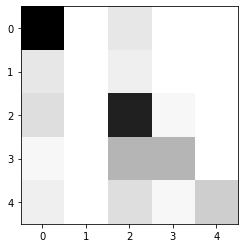

In [47]:
score=0
for j in range(25):
  for i,(img,lbl) in enumerate(test_generator):
    pred_y_tta[4*i:4*i+4]=model.predict(img)
    test_y_[4*i:4*i+4,:]=lbl
    if i==25:
      break
  cm_=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
  score_=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
  if score_>score:
    score=score_
    cm=cm_
print(cm)
plt.imshow(cm, cmap='binary')
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_tta,axis=1),np.argmax(test_y_,axis=1)))

(array([34.,  0.,  5.,  0.,  0., 32.,  0., 19.,  0., 13.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

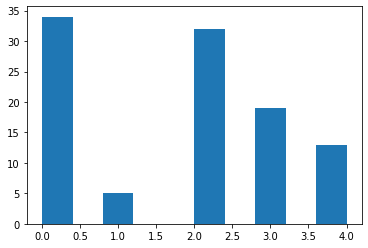

In [40]:
plt.hist(np.argmax(test_y_,axis=1))

## save model to disk

In [41]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/IDRid/Experimental models/69_ben8_eff4_Late_fusion_les_based_atten_ident_3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/IDRid/Experimental models/69_ben8_eff4_Late_fusion_les_based_atten_ident_3.h5")
print("Saved model to disk")

Saved model to disk


## test on best validation model

In [48]:
#model_1=build_model(5,'EfficientNetB4')
model_1=model
model_1.load_weights("weights.07-0.71.hdf5") 

[[24  2  8  0  0]
 [ 4  0  1  0  0]
 [ 5  0 18  9  0]
 [ 1  0  5  9  4]
 [ 1  0  4  3  5]]
0.5436893203883495  acuracy
quadratic kappa  0.6921575892305792


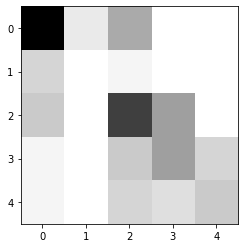

In [49]:
pred_y_=np.zeros((test_labels.shape))
for i in range(25):
  pred_y_[4*i:4*i+4]=model_1.predict(test_images[4*i:4*i+4])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(test_labels,axis=1)))

In [ ]:
for i,(img,lbl) in enumerate(x):
  pred_y_tta[6*i:6*i+6]=model_1.predict(img)
  test_y_[6*i:6*i+6,:]=lbl
  if i==16:
    break
cm=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_tta,axis=1),np.argmax(test_y_,axis=1)))